# Kronecker Structured Covariances

PyMC3 contains implementations for models that have Kronecker structured covariances.  This patterned structure enables Gaussian process models to work on much larger datasets.  Kronecker structure can be exploited when
- The dimension of the input data is greater than two ($\mathbf{x} \in \mathbb{R}^{d}\,, d > 2$)
- The influence of the process across each dimension is *separable*
- The kernel can be written as a product over dimension, without cross terms:

$$k(\mathbf{x}, \mathbf{x'}) = \prod_{i = 1}^{d} k(\mathbf{x}_{i}, \mathbf{x'}_i) \,.$$

The covariance matrix that corresponds to the covariance function above can be written with a *Kronecker product*

$$
\mathbf{K} = \mathbf{K}_2 \otimes \mathbf{K}_2 \otimes \cdots \otimes \mathbf{K}_d \,.
$$

These implementations support the following property of Kronecker products to speed up calculations, $(\mathbf{K}_1 \otimes \mathbf{K}_2)^{-1} = \mathbf{K}_{1}^{-1} \otimes \mathbf{K}_{2}^{-1}$, the inverse of the sum is the sum of the inverses.  If $K_1$ is $n \times n$ and $K_2$ is $m \times m$, then $\mathbf{K}_1 \otimes \mathbf{K}_2$ is $mn \times mn$.  For $m$ and $n$ of even modest size, this inverse becomes impossible to do efficiently.  Inverting two matrices, one $n \times n$ and another $m \times m$ is much easier.

This structure is common in spatial and image data for example, or perhaps time series data that has covariates.  Given that there is Kronecker structure in the covariance matrix, this implementation is exact --- not an approximation to the full Gaussian process.  PyMC3 contains two implementations that follow the same pattern as `gp.Marginal` and `gp.Latent`.  For Kronecker structured covariances where the data likelihood is Gaussian, use `gp.MarginalKron`.  For Kronecker structured covariances where the data likelihood is non-Gaussian, use `gp.LatentKron`.  

Our implementations follow [Saatchi's Thesis](http://mlg.eng.cam.ac.uk/pub/authors/#Saatci).  `MarginalKron` follows "Algorithm 16" using the Eigendecomposition, and `LatentKron` follows "Algorithm 14", and uses the Cholesky decomposition.

## `MarginalKron`

The following is a canonical example of the usage of `MarginalKron`.  Like `Marginal`, this model assumes that the underlying GP is unobserved, but the sum of the GP and normally distributed noise are observed.  

For the simulated data set, we draw one sample from a Gaussian process whose covariance is Kronecker structured.  Then we use `MarginalKron` to recover the unknown Gaussian process hyperparameters $\theta$ that were used to simulate the data.

### Example

We'll simulate a two dimensional data set and display it as a scatter plot whose points are colored by magnitude.  The two dimensions are labeled `x1` and `x2`.  This could be a spatial dataset, for instance.  The covariance will have a Kronecker structure since the points lie on a two dimensional grid.

In [1]:
import pymc3 as pm
import theano.tensor as tt
import numpy as np
import matplotlib as mpl
plt = mpl.pyplot
%matplotlib inline

In [2]:
np.random.seed(1234)

# One dimensional column vectors of inputs
n1, n2 = (50, 30)
x1 = np.linspace(0, 5, n1)
x2 = np.linspace(0, 3, n2)

# make cartesian grid out of each dimension x1 and x2
X = pm.math.cartesian(x1[:,None], x2[:,None])

l1_true = 0.8
l2_true = 1.0
eta_true = 1.0

# Although we could, we don't exploit kronecker structure to draw the sample
cov = eta_true**2 * pm.gp.cov.Matern52(2, l1_true, active_dims=[0]) *\
                    pm.gp.cov.Cosine(2, ls=l2_true, active_dims=[1])

K = cov(X).eval()
f_true = np.random.multivariate_normal(np.zeros(X.shape[0]), K, 1).flatten()

sigma_true = 0.25
y = f_true + sigma_true * np.random.randn(X.shape[0])

The lengthscale along the `x2` dimension is longer than the lengthscale along the `x1` direction (`l1_true` < `l2_true`).  

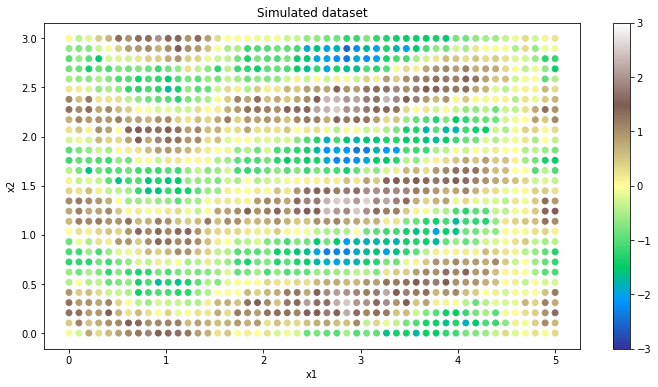

In [3]:
fig = plt.figure(figsize=(12,6))
ax = fig.gca(); cmap = 'terrain'
norm = mpl.colors.Normalize(vmin=-3, vmax=3)
plt.scatter(X[:,0], X[:,1], s=35, c=y, marker='o', norm=norm, cmap=cmap); plt.colorbar();
plt.xlabel("x1"); plt.ylabel("x2"); plt.title("Simulated dataset");

There are 1500 data points in this data set.  Without using the factorization, finding the MAP estimate would be much slower.

Since the two covariances are a product, we only scale one of them with the parameter `eta`.

In [4]:
# this implementation takes a list of inputs for each dimension as input
Xs = [x1[:,None], x2[:,None]]

with pm.Model() as model:
    # Set priors on the hyperparameters of the covariance
    ls1  = pm.Gamma("ls1", alpha=2, beta=2)
    ls2  = pm.Gamma("ls2", alpha=2, beta=2)
    eta = pm.HalfNormal("eta", sigma=2)
    
    # Specify the covariance functions for each Xi
    # Since the covariance is a product, only scale one of them by eta.
    # Scaling both overparameterizes the covariance function. 
    cov_x1 = pm.gp.cov.Matern52(1, ls=ls1)        # cov_x1 must accept X1 without error
    cov_x2 = eta**2 * pm.gp.cov.Cosine(1, ls=ls2) # cov_x2 must accept X2 without error

    # Specify the GP.  The default mean function is `Zero`.
    gp = pm.gp.MarginalKron(cov_funcs=[cov_x1, cov_x2])

    # Set the prior on the variance for the Gaussian noise
    sigma = pm.HalfNormal("sigma", sigma=2)
    
    # Place a GP prior over the function f.
    y_ = gp.marginal_likelihood("y", Xs=Xs, y=y, sigma=sigma)

In [5]:
with model:
    mp = pm.find_MAP(method="BFGS")

/projects/pymc3/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -106.56, ||grad|| = 178.34: 100%|██████████| 48/48 [00:01<00:00, 47.81it/s]  


In [6]:
mp

{'ls1_log__': array(0.06097508),
 'ls2_log__': array(0.00235805),
 'eta_log__': array(0.39013477),
 'sigma_log__': array(-1.40229281),
 'ls1': array(1.06287243),
 'ls2': array(1.00236083),
 'eta': array(1.47717986),
 'sigma': array(0.24603221)}

Next we use the map point `mp` to extrapolate in a region outside the original grid.  We can also interpolate.  There is no grid restriction on the new inputs where predictions are desired.  Having a grid structure in these points also doesn't produce any efficiency gains.  The plot with the extrapolations is shown below.  The original data is marked with circles as before, but the extrapolated mean is marked with squares.

In [7]:
x1new = np.linspace(5.1, 7.1, 20)
x2new = np.linspace(-0.5, 3.5, 40)
Xnew = pm.math.cartesian(x1new[:,None], x2new[:,None])

mu, var = gp.predict(Xnew, point=mp, diag=True)

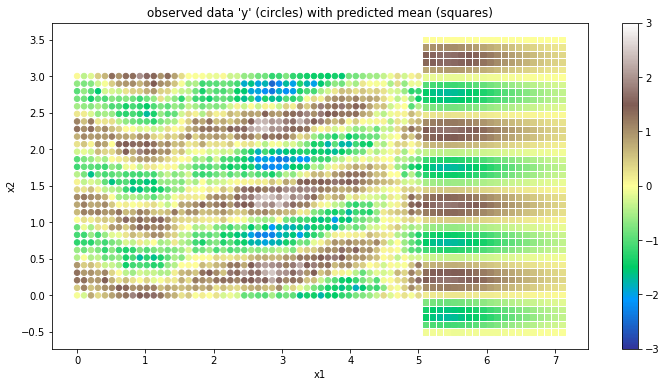

In [8]:
fig = plt.figure(figsize=(12,6))
ax = fig.gca(); cmap = 'terrain'
norm = mpl.colors.Normalize(vmin=-3, vmax=3)
m=ax.scatter(X[:,0], X[:,1], s=30, c=y, marker='o', norm=norm, cmap=cmap); plt.colorbar(m);
ax.scatter(Xnew[:,0], Xnew[:,1], s=30, c=mu, marker='s', norm=norm, cmap=cmap);
ax.set_ylabel("x2"); ax.set_xlabel("x1")
ax.set_title("observed data 'y' (circles) with predicted mean (squares)");

## `LatentKron`

Like the `gp.Latent` implementation, the `LatentKron` implementation specifies a Kronecker structured GP regardless of context.  **It can be used with any likelihood function, or can be used to model a variance or some other unobserved processes**.  The syntax follows that of `gp.Latent` exactly.  

### Example 1

To compare with `MarginalLikelihood`, we use same example as before where the noise is normal, but the GP itself is not marginalized out.  Instead, it is sampled directly using NUTS.  It is very important to note that `LatentKron` does not require a Gaussian likelihood like `MarginalKron`; rather, any likelihood is admissable.

In [9]:
with pm.Model() as model:
    # Set priors on the hyperparameters of the covariance
    ls1 = pm.Gamma("ls1", alpha=2, beta=2)
    ls2 = pm.Gamma("ls2", alpha=2, beta=2)
    eta = pm.HalfNormal("eta", sigma=2)
    
    # Specify the covariance functions for each Xi
    cov_x1 = pm.gp.cov.Matern52(1, ls=ls1)       
    cov_x2 = eta**2 * pm.gp.cov.Cosine(1, ls=ls2)

    # Set the prior on the variance for the Gaussian noise
    sigma = pm.HalfNormal("sigma", sigma=2)

    # Specify the GP.  The default mean function is `Zero`.
    gp = pm.gp.LatentKron(cov_funcs=[cov_x1, cov_x2])
    
    # Place a GP prior over the function f.
    f = gp.prior("f", Xs=Xs)
    
    y_ = pm.Normal("y_", mu=f, sd=sigma, observed=y)


In [10]:
with model:
    tr = pm.sample(500, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/miniconda3/envs/pymc33.6/lib/python3.6/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/miniconda3/envs/pymc33.6/lib/python3.6/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/miniconda3/envs/pymc33.6/lib/python3.6/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing i

The posterior distribution of the unknown lengthscale parameters, covariance scaling `eta`, and white noise `sigma` are shown below.  The vertical lines are the true values that were used to generate the original data set. 

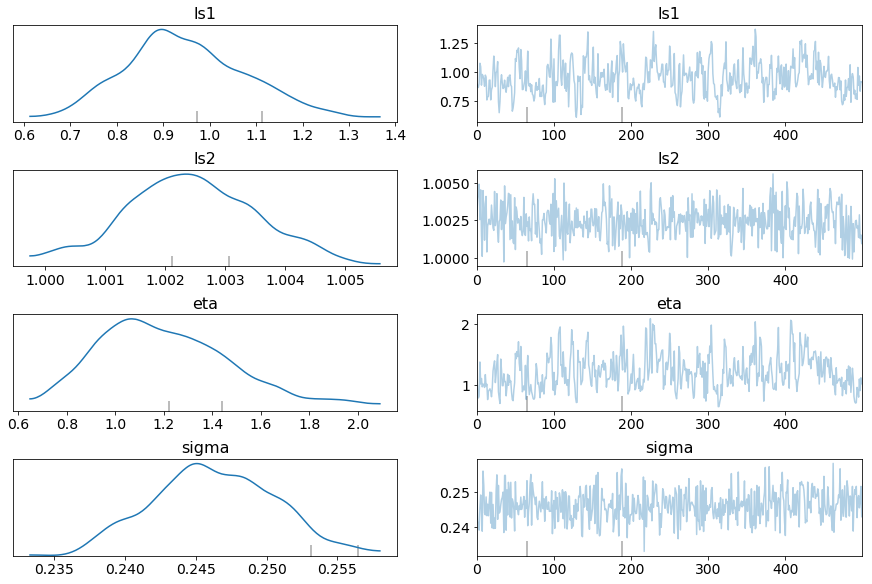

In [11]:
pm.traceplot(tr, var_names=["ls1", "ls2", "eta", "sigma"], 
             lines={"ls1": l1_true, "ls2": l2_true, "eta": eta_true, "sigma": sigma_true});

In [12]:
x1new = np.linspace(5.1, 7.1, 20)
x2new = np.linspace(-0.5, 3.5, 40)
Xnew = pm.math.cartesian(x1new[:,None], x2new[:,None])

with model:
    fnew = gp.conditional("fnew", Xnew)
    
with model:
    ppc = pm.sample_posterior_predictive(tr, 200, vars=[fnew])

100%|██████████| 200/200 [05:31<00:00,  1.42s/it]


Below we show the original data set as colored circles, and the mean of the conditional samples as colored squares.  The results closely follow those given by the `MarginalKron` implementation.

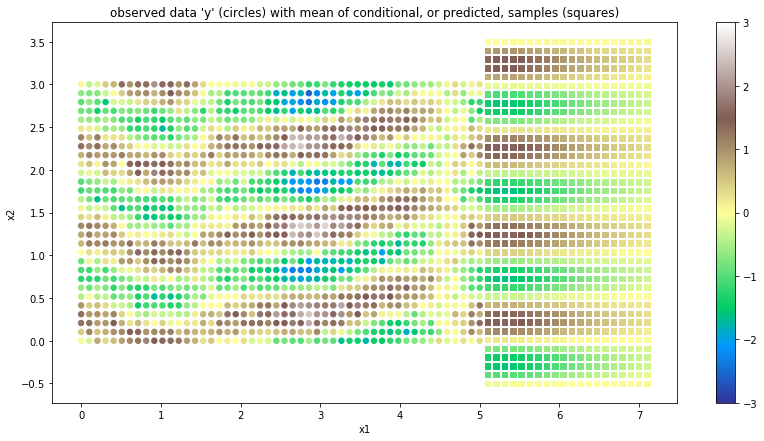

In [13]:
fig = plt.figure(figsize=(14,7))
ax = fig.gca(); cmap = 'terrain'
norm = mpl.colors.Normalize(vmin=-3, vmax=3)
m=ax.scatter(X[:,0], X[:,1], s=30, c=y, marker='o', norm=norm, cmap=cmap); plt.colorbar(m);
ax.scatter(Xnew[:,0], Xnew[:,1], s=30, c=np.mean(ppc["fnew"], axis=0), marker='s', norm=norm, cmap=cmap);
ax.set_ylabel("x2"); ax.set_xlabel("x1")
ax.set_title("observed data 'y' (circles) with mean of conditional, or predicted, samples (squares)");

Next we plot the original data set (circles), along with four samples from the conditional distribution, `fnew` (squares).  As we can see, the level of variation in the conditional, or predictive, distribution is somewhat large.  However, it's samples make sense given the variation in the data.  There are essentially seamless connections between the original data set and the samples from the conditional distribution.

6 samples from GP posterior 'f' (circles), with 4 samples from conditional 'fnew' (squares)


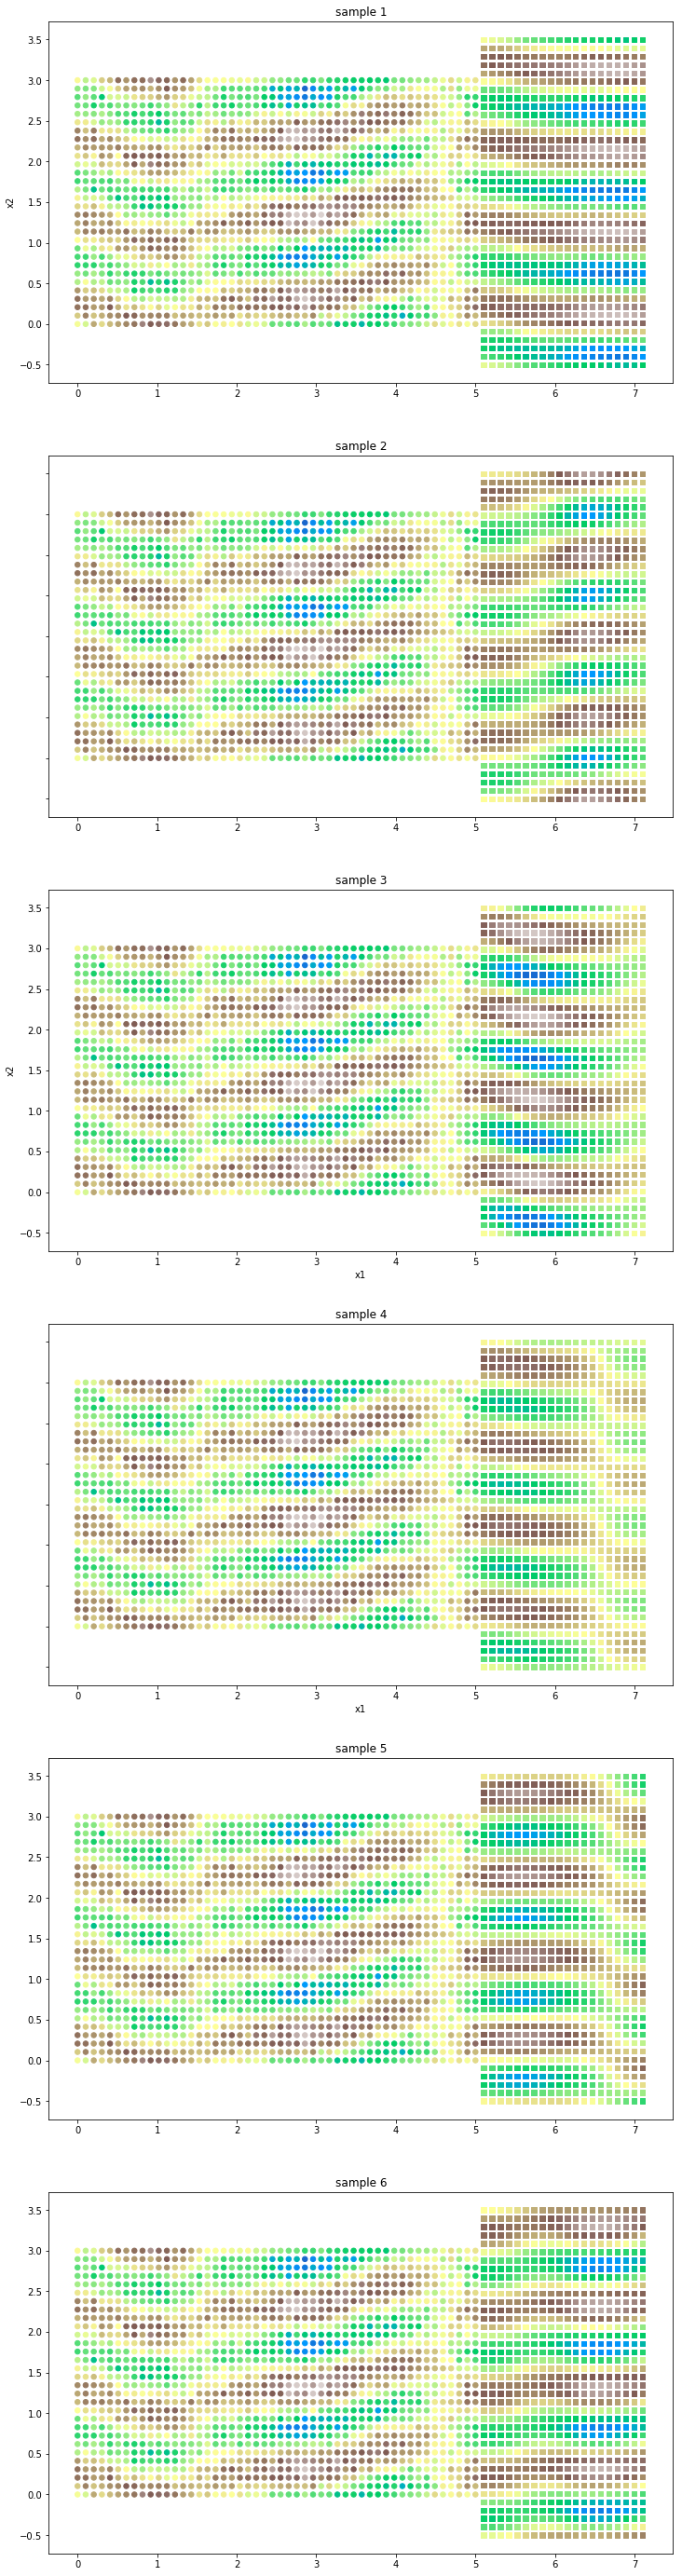

In [14]:
fig, axs = plt.subplots(6,1, figsize=(12,50))
print("6 samples from GP posterior 'f' (circles), with 4 samples from conditional 'fnew' (squares)")
axs = list(axs.flatten())
for i, ax in enumerate(axs):
    if i in (1,3):
        ax.set_yticklabels([])
    if i in (0,2):
        ax.set_ylabel("x2")
    if i in (2,3):
        ax.set_xlabel("x1")
    norm = mpl.colors.Normalize(vmin=-3, vmax=3)
    ax.scatter(X[:,0], X[:,1], s=30, c=y, marker='o', norm=norm, cmap=cmap); 
    ax.scatter(Xnew[:,0], Xnew[:,1], s=30, c=ppc["fnew"][i], marker='s', norm=norm, cmap=cmap);
    ax.set_title("sample "+str(i + 1))